In [49]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
#!pip install deepxde==0.10.0
import deepxde as dde
import scipy as sp
import scipy.interpolate as interp
from deepxde.backend import tf
from matplotlib import pyplot as plt
from numpy.core.shape_base import hstack
from scipy import signal
# from param import *
loc_drive=""
path_subrotinas="/home/taniel/Desktop/Projetos_Deep/BCS/subrotinas.py"
exec(compile(open('param_LEA.py', "rb").read(), 'param_LEA.py', 'exec')) #% Roda arquivo com parâmetros do modelo BCS
exec(compile(open(path_subrotinas, "rb").read(), path_subrotinas, 'exec'))
exec(compile(open('exp_LEA.py', "rb").read(), 'exp_LEA.py', 'exec')) 

0.24108276567583545 7.559321788388188 [-11.492505101438962, 204.43014465827954]
Dados carregados


In [3]:
# =========================================================================
#  Define as entradas do BCS LEA   
# =========================================================================
#   freq = Cexp.referencia_frequencia_inversor(1:nsim)*0.1;                   % [Hz] frequencia de operacao
intervalo=np.array([int(1*3600),int(5*3600)])
#intervalo=np.array([int(0*3600),int(7.8*3600)])

#intervalo=np.array([1.8,3])
LEA=dados_LEA_Exp(loc_drive+'Dados_BCSLEA_20210818.mat',intervalo)
pm=LEA['pressao_manifold_coriolis']*1e5
pr=LEA['pressao_reservatorio']*1e5
pm_0=pm[0]
pr_0=pr[0]
u_0=np.array([LEA['referencia_frequencia_inversor'][0],LEA['valvula_pneumatica_topo'][0],pm_0,pr_0])
x_0=np.array([LEA['pressao_fundo'][0]*1e5,LEA['pressao_choke'][0]*1e5,LEA['vazao'][0]/3600])
u_0
nsim=LEA['tempo']+1
ts=LEA['Ts']
tempo_hora = np.arange(0,nsim*ts,ts)/3600

1


In [4]:
#========================
# Filtragem Pman=========
fs=1/ts
fs
Wn=2*pi*fs/1.2
input_signal=np.reshape(pm,(1,nsim))
b, a = sp.signal.butter(2, Wn, 'low')
output_signal = np.reshape(sp.signal.filtfilt(b, a, input_signal),(nsim))

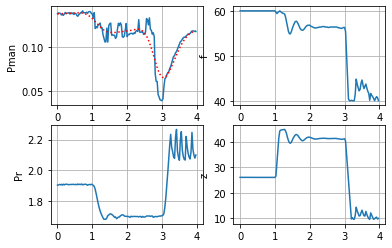

In [5]:
fig3=plt.figure()
label = ['Pman','Pr','f','z'];
ax1=fig3.add_subplot(2,2,1)
ax1.plot(tempo_hora,pm/1e5, label='Pman')
ax1.plot(tempo_hora,output_signal/1e5, ':r')
ax1.set_ylabel(label[0])
plt.grid(True)
ax2=fig3.add_subplot(2,2,3)
ax2.plot(tempo_hora,pr/1e5, label='Pr')
ax2.set_ylabel(label[1])
plt.grid(True)
ax3=fig3.add_subplot(2,2,2)
ax3.plot(tempo_hora,LEA['referencia_frequencia_inversor'], label='f')
ax3.set_ylabel(label[2])
plt.grid(True)
ax4=fig3.add_subplot(2,2,4)
ax4.plot(tempo_hora,LEA['valvula_pneumatica_topo'], label='z')
ax4.set_ylabel(label[3])
plt.grid(True)

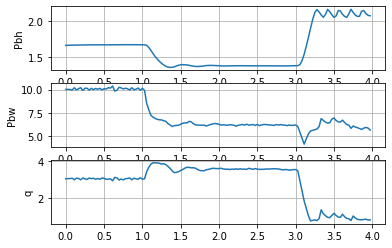

In [6]:
fig4=plt.figure()
label = ['Pbh','Pbw','q'];
ax1=fig4.add_subplot(3,1,1)
ax1.plot(tempo_hora ,LEA['pressao_fundo'], label='Pman')
ax1.set_ylabel(label[0])
plt.grid(True)
ax2=fig4.add_subplot(3,1,2)
ax2.plot(tempo_hora,LEA['pressao_choke'], label='Pr')
ax2.set_ylabel(label[1])
plt.grid(True)
ax3=fig4.add_subplot(3,1,3)
ax3.plot(tempo_hora,LEA['vazao'], label='q')
ax3.set_ylabel(label[2])
plt.grid(True)


Estudo das Fricções
Turbulento - Laminar

In [7]:
# def Friction(qan):
#   Re_1 =(4*rho_1*qan)/(0.219*pi*mu); # Assuming identicals rho and same Re and fric as consequence
#   F_2=np.zeros_like(qan)
#   F_1=F_2
#   for i in np.arange(0,len(qan)):
#     if Re_1[i]<4000:
#       fric_1=64/Re_1[i]
#     else:
#       fric_1=0.36*Re_1[i]**(-0.25)
#     F_1[i] = (fric_1*qan[i]**2*rho_1)/(2*pi*r2**3)
#     F_2[i] = (fric_1*qan[i]**2*rho_1)/(2*pi*r1**3)
#   return F_1,F_2

# qi=np.linspace(qlim[0],qlim[1],100)
# qi=np.linspace(qlim[0],40/3600,100)
# F1,F2=Friction(qi)


# fig=plt.figure()
# label = ['F1','F2','Re'];
# ax1=fig.add_subplot(3,1,1)
# ax1.plot(qi*3600 ,F1, label='F1')
# ax1.set_ylabel(label[0])
# plt.grid(True)
# ax2=fig.add_subplot(3,1,2)
# ax2.plot(qi*3600 ,F2, label='F2')
# ax2.set_ylabel(label[1])
# plt.grid(True)
# ax3=fig.add_subplot(3,1,3)
# ax3.plot(qi*3600 ,(4*rho_1*qi)/(0.219*pi*mu), label='Re')
# ax3.set_ylabel(label[2])
# ax3.set_xlabel("m³/h")
# plt.grid(True)

# print("Limite Laminar 4000 implica em q <",((0.219*pi*mu/(4*rho_1))*4000)*3600)
# print("Limite Laminar 2000 implica em q <",((0.219*pi*mu/(4*rho_1))*2000)*3600)

In [8]:
fk=LEA['referencia_frequencia_inversor']
zc=LEA['valvula_pneumatica_topo']
fk=np.reshape(fk, (nsim,1))
zc=np.reshape(zc, (nsim,1))
pm=np.reshape(pm, (nsim,1))
pr=np.reshape(pr, (nsim,1))
# time points
maxtime = nsim
time = np.linspace(0, nsim, nsim)
time.shape
nsim

144

In [9]:
def constante(valor,time_vector):
    return np.ones_like(time_vector)*valor

def ex_func(t):
  # loads exogenous inputs and interpolates intersample if necessary
    spline_f = sp.interpolate.Rbf(
        time, fk, function="thin_plate", smooth=0, episilon=0
    )
    spline_zc = sp.interpolate.Rbf(
        time, zc, function="thin_plate", smooth=0, episilon=0
    )
    spline_pman = sp.interpolate.Rbf(
        time, pm, function="thin_plate", smooth=0, episilon=0
    )
    spline_pres = sp.interpolate.Rbf(
        time, pr, function="thin_plate", smooth=0, episilon=0
    )
    #out=np.array([spline_f(t), spline_zc(t), spline_pman(t), spline_pres(t)])
    return [spline_f(t), spline_zc(t), spline_pman(t), spline_pres(t)]
    # out=np.hstack([np.array([spline_f(t)]).T,np.array([spline_zc(t)]).T,np.array([spline_pman(t)]).T,np.array([spline_pres(t)]).T ])
    # return out #np.transpose(out)


In [10]:
#ex=ex_func(time)
#ex.shape
# a=np.array([[4],[5],[3]])
# a.T

In [11]:

# fx=ex[:,0:1]; 
# zx=ex[:,1:2];
# pmx=ex[:,2:3];
# prx=ex[:,3:]
# output_signal.shape

# ex[:,0:1].shape
# #prx.shape

In [12]:
# #Teste das ex_func
# fig3=plt.figure()

# label = ['Pman','Pr','f','z'];
# ax1=fig3.add_subplot(2,2,1)
# ax1.plot(time/3600 ,pmx/1e5, label='Pman')
# ax1.plot(time/3600,output_signal/1e5, ':r')
# ax1.set_ylabel(label[0])
# plt.grid(True)
# ax2=fig3.add_subplot(2,2,3)
# ax2.plot(time/3600,prx/1e5, label='Pr')
# ax2.set_ylabel(label[1])
# plt.grid(True)
# ax3=fig3.add_subplot(2,2,2)
# ax3.plot(time/3600,fx, label='f')
# ax3.set_ylabel(label[2])
# plt.grid(True)
# ax4=fig3.add_subplot(2,2,4)
# ax4.plot(time/3600,zx, label='z')
# ax4.set_ylabel(label[3])
# plt.grid(True)

In [13]:
math.log(818)

6.706862336602747

In [14]:
# Entradas
# Valores máximos e mínimos para normalização
#Entradas - conforme binder e pavlov
#========================================
pbc=Lim_c(pbhlim)
pwc=Lim_c(pwhlim)
qc=Lim_c(qlim)
pbmin=pbhlim[0]
pwmin=pwhlim[0]
qmin=qlim[0]


#rho=tf.log(tf.Variable(tf.exp(8.18)))*100 #836.8898 log(exp) impede valores negativos
rho=tf.exp(tf.Variable(6.7))
#rho=tf.Variable(tf.exp(818.0))
PI = tf.Variable(2.5)*1e-8 ##PI = 2.7e-8; # Well productivy index [m3/s/Pa]
xc=np.array([pbc,pwc,qc])
x0=np.array([pbmin,pwmin,qmin])
x_0=np.array([LEA['pressao_fundo'][0]*1e5,LEA['pressao_choke'][0]*1e5,LEA['vazao'][0]/3600])
x1=(LEA['pressao_fundo']*1e5-x0[0])/xc[0]
x2=(LEA['pressao_choke']*1e5-x0[1])/xc[1]
x3=(LEA['vazao']/3600-x0[2])/xc[2]
x1=x1.reshape(nsim,1)
x2=x2.reshape(nsim,1)
x3=x3.reshape(nsim,1)
tempo=np.arange(0,nsim)
tempo=tempo.reshape(len(x1),1)


# Fig_LEA_data(LEA)

# a=np.array([1,2,3,4,5,6,7])
# a[:3]
xss=x_0
xss
math.log(3.57e3)

8.180320874773685

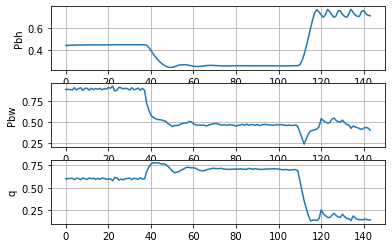

In [15]:
fig4=plt.figure()
label = ['Pbh','Pbw','q'];
ax1=fig4.add_subplot(3,1,1)
ax1.plot(tempo ,x1, label='x1n')
ax1.set_ylabel(label[0])
plt.grid(True)
ax2=fig4.add_subplot(3,1,2)
ax2.plot(tempo ,x2, label='x2n')
ax2.set_ylabel(label[1])
plt.grid(True)
ax3=fig4.add_subplot(3,1,3)
ax3.plot(tempo ,x3, label='x3n')
ax3.set_ylabel(label[2])
plt.grid(True)

In [16]:
# #Teste das ex_func
# fig3=plt.figure()
# uu=np.transpose(ex_func(time))
# label = ['Pman','Pr','f','z'];
# ax1=fig3.add_subplot(2,2,1)
# ax1.plot(time/3600 ,uu[2]/1e5, label='Pman')
# ax1.set_ylabel(label[0])
# plt.grid(True)
# ax2=fig3.add_subplot(2,2,3)
# ax2.plot(time/3600,uu[3]/1e5, label='Pr')
# ax2.set_ylabel(label[1])
# plt.grid(True)
# ax3=fig3.add_subplot(2,2,2)
# ax3.plot(time/3600,uu[0], label='f')
# ax3.set_ylabel(label[2])
# plt.grid(True)
# ax4=fig3.add_subplot(2,2,4)
# ax4.plot(time/3600,uu[1], label='z')
# ax4.set_ylabel(label[3])
# plt.grid(True)

In [17]:
F1c=2.92634e-05
F2c=0.000738599
Hc=215.9226497597185
qcc=0.0020328441729756536
F1lim=(0.000439365,0.000439365)
F2lim=(0.0110894,0.0110894)

In [18]:

def ED_BCS(t,x,ex_func):
    ## Montado o sistema de equa��es
    # Tensores (Estados)
    pbh = x[:,0:1]
    pwh = x[:,1:2]
    q = x[:,2:] #Vazão

    # fq=ex_func[:,0:1]
    # zc=ex_func[:,1:2]
    # pman=ex_func[:,2:3];#pman=0.12e5
    # pres=ex_func[:,3:4]

    # fq=ex_func[:,0]
    # zc=ex_func[:,1]
    # pman=ex_func[:,2];#pman=0.12e5
    # pres=ex_func[:,3]

    fq=ex_func[0]
    zc=ex_func[1]
    pman=ex_func[2];#pman=0.12e5
    pres=ex_func[3]

    # fq=50
    # zc=35
    # pman=0.12e5
    # pres=1.8e5

    #=============================================
    # Computing HEAD and pump pressure gain of LEA
    q0 = (qc*q+qmin) / Cq * (f0 / fq)
    H0 =  Head[0]*q0**4 +  Head[1]*q0**3 +  Head[2]*q0**2 + Head[3]*q0 + Head[4];
    H = CH * H0 * (fq / f0) ** 2  # Head
    #Pp = rho * g * H  # Dp
    #==============================================
    # Electrical power and electrical current computing
    #P0 = -2.3599e9 * q0 ** 3 - 1.8082e7 * q0 ** 2 + 4.3346e6 * q0 + 9.4355e4
    #P = Cp * P0 * (fq / f0) ** 3;  
    #I = Inp * P / Pnp  
    #==============================================
    # Computing two volumes frictions in LEA piping
    qan=q*qc+qmin # non normalized flow
    Re =(4*rho*qan)/(0.219*pi*mu); # Assuming volumes density are identicals
    fric=64/Re 
     
    F1 = (fric*qan**2*rho)/(2*pi*r1**3) #Frictional pressure drop above ESP (Assuming laminar flow)
    F2 = (fric*qan**2*rho)/(2*pi*r2**3) #Frictional pressure drop above ESP (Assuming laminar flow)
    #===========================================
    #===========================================
    # Computing intake pressure
    #pin = pbh*pbc+pbmin - rho * g * h1 - F1;
    # Computing Reservoir flow
    qr = PI * (pres - (pbh*pbc+pbmin));
    # Computing flow across Choke valvule
    qch = Cc * (zc) * tf.sqrt(tf.abs(pwh*pwc+pwmin - pman)); # Algumas operações precisam usar o prefixo do tensorflow 
    #============================================

    #Normalizing nonlinear terms
    ##########################
    qch=(qch-qch_lim[0])/qcc
    F1=(F1-F1lim[0])/F1c
    F2=(F2-F2lim[0])/F2c
    H=(H-H_lim[0])/Hc
    ###########################
    #xss=np.float32(np.array([2.0197e5,4.9338e5,4.2961e-4]));
  
    # SEDO

    dpbhdt = dde.grad.jacobian(x, t, i=0)
    dpwhdt = dde.grad.jacobian(x, t, i=1)
    dqdt = dde.grad.jacobian(x, t, i=2)

    return [
        dpbhdt - (1/pbc)*b1/V1*(qr - (q*qc+qmin)),
        dpwhdt - (1/pwc)*b2/V2*((q*qc+qmin) - (qcc*qch+qch_lim[0])),
        dqdt - (1/(qc*M))*(pbh*pbc+pbmin - (pwh*pwc+pwmin) - rho*g*hw - (F1c*F1+F1lim[0]) - (F2c*F2+F2lim[0]) + rho * g * (H*Hc+H_lim[0]))
        ]


    

In [19]:
# #==========================
# #Testar EDOs = Calcular alguns resíduos =========
# n=10
# fq=fx[n];zc=zx[n];pman=pmx[n];pres=prx[n]
# q=x3[n];pbh=x1[n];pwh=x2[n]
# rho=rho_1
# PI=2.7e-8
# #=============================================
# # Computing HEAD and pump pressure gain of LEA
# q0 = (qc*q+qmin) / Cq * (f0 / fq)
# H0 =  Head[0]*q0**4 +  Head[1]*q0**3 +  Head[2]*q0**2 + Head[3]*q0 + Head[4];
# H = CH * H0 * (fq / f0) ** 2  # Head
# Pp = rho * g * H  # Dp
# #==============================================
# # Electrical power and electrical current computing
# P0 = -2.3599e9 * q0 ** 3 - 1.8082e7 * q0 ** 2 + 4.3346e6 * q0 + 9.4355e4
# #P = Cp * P0 * (fq / f0) ** 3;  
# #I = Inp * P / Pnp  
# #==============================================
# # Computing two volumes frictions in LEA piping
# qan=q*qc+qmin # non normalized flow
# Re =(4*rho*qan)/(0.219*pi*mu); # Assuming volumes density are identicals
# fric=64/Re 
  
# F1 = (fric*qan**2*rho)/(2*pi*r1**3) #Frictional pressure drop above ESP (Assuming laminar flow)
# F2 = (fric*qan**2*rho)/(2*pi*r2**3) #Frictional pressure drop above ESP (Assuming laminar flow)
# #===========================================
# #===========================================
# # Computing intake pressure
# pin = pbh*pbc+pbmin - rho * g * h1 - F1;
# # Computing Reservoir flow
# qr = PI * (pres - (pbh*pbc+pbmin));
# # Computing flow across Choke valvule
# qch = Cc * (zc) * math.sqrt(abs(pwh*pwc+pwmin - pman)); # Algumas operações precisam usar o prefixo do tensorflow 
# #============================================
# # Nonlinear terms analysis
# # funcF1=Function('funcF1',[x],[F1])
# # funcF2=Function('funcF2',[x],[F2])
# # funcH=Function('funcH',[x,u],[H])
# # funcqch=Function('funqch',[x,u],[qch])
# #F1lim=(funcF1([0,0,qlim[0]]),funcF1([0,0,qlim[1]])) # Limits  F1
# #F2lim=(funcF2([0,0,qlim[0]]),funcF2([0,0,qlim[1]])) # Limits  F2
# # F1c=Lim_c(F1lim) # characteristic value F1
# # F2c=Lim_c(F2lim) # characteristic value F2
# # Hc=Lim_c(H_lim) # characteristic value H
# #qcc=Lim_c(qch_lim) # characteristic value qch
# F1c=2.92634e-05
# F2c=0.000738599
# Hc=215.9226497597185
# qcc=0.0020328441729756536
# F1lim=(0.000439365,0.000439365)
# F2lim=(0.0110894,0.0110894)
# #Normalizing nonlinear terms
# ##########################
# qch=(qch-qch_lim[0])/qcc
# F1=(F1-F1lim[0])/F1c
# F2=(F2-F2lim[0])/F2c
# H=(H-H_lim[0])/Hc
# [(1/pbc)*b1/V1*(qr - (q*qc+qmin)),
# (1/pwc)*b2/V2*((q*qc+qmin) - (qcc*qch+qch_lim[0])),
# (1/(qc*M))*(pbh*pbc+pbmin - (pwh*pwc+pwmin) - rho*g*hw - (F1c*F1+F1lim[0]) - (F2c*F2+F2lim[0]) + rho * g * (H*Hc+H_lim[0]))]


In [20]:
def boundary(_, on_initial):
    return on_initial


x_0 = np.float32(xss)
xssn = (x_0-x0)/xc
geom = dde.geometry.TimeDomain(0, nsim)

ic1 = dde.IC(geom, lambda v: xssn[0], boundary, component=0)
ic2 = dde.IC(geom, lambda v: xssn[1], boundary, component=1)
ic3 = dde.IC(geom, lambda v: xssn[2], boundary, component=2)



observe_x1 = dde.PointSetBC(tempo, x1, component=0)
observe_x2 = dde.PointSetBC(tempo, x2, component=1)
observe_x3 = dde.PointSetBC(tempo, x3, component=2)


In [21]:
data = dde.data.PDE(
    #geom, ED_BCS, [ic1,ic2,ic3],
    #geom, ED_BCS, [ic1,ic2,ic3,observe_x1,observe_x2,observe_x3],
    #geom, ED_BCS, [ic1,ic2,ic3,observe_x1,observe_x2],
    geom, ED_BCS, [observe_x1,observe_x2],
    #geom, ED_BCS, [ic1,ic2,ic3,observe_x1],
    #solution=func,
    num_test=2000,
    num_domain=6000,
    #num_boundary=2,
    #anchors=tempo,
    auxiliary_var_function=ex_func
    )

In [22]:

passos=10000

layer_size = [1] + [30]*6 + [3]
activation = "tanh" # 
#activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
#                   batch_normalization="before")
# callbacks for storing results
fnamevar = "LEA_rho_PI.dat"
variable = dde.callbacks.VariableValue([rho,PI], period=100, filename=fnamevar)
model = dde.Model(data, net)
checker = dde.callbacks.ModelCheckpoint(
        "model_norm/modelo.ckpt", save_better_only=True)
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
cb=[variable,checker,early_stopping]
#cb=[checker]
#cb=None


In [23]:
model.compile("adam", lr=0.001)



Compiling model...
Building feed-forward neural network...
'build' took 0.113706 s



/home/taniel/anaconda3/envs/RC/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/taniel/anaconda3/envs/RC/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.483881 s



In [24]:
c.

SyntaxError: invalid syntax (<ipython-input-24-cf463a5954f9>, line 1)

Compiling model...
'compile' took 1.375032 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.66e+03, 5.19e+01, 1.20e+05, 4.10e-01, 2.12e-01]    [3.67e+03, 5.20e+01, 1.20e+05, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model_norm/modelo.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
1000      [1.15e+02, 1.01e+02, 2.05e+03, 2.28e-02, 4.35e-02]    [1.15e+02, 1.01e+02, 2.05e+03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model_norm/modelo.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [3.49e+01, 1.36e+01, 4.75e+02, 3.16e-02, 1.05e-01]    [3.50e+01, 1.36e+01, 4.76e+02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model_norm/modelo.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.
3000      [1.65e+01, 1.13e+01, 2.43e+02, 4.41e-02, 1.18e-01]    [1.65e+01, 1.13e+01, 2.43e+02, 0.00e+00, 0.

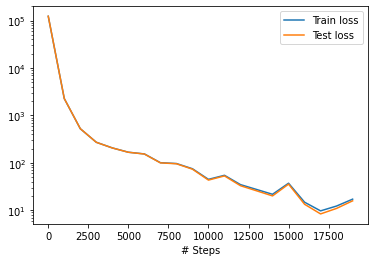

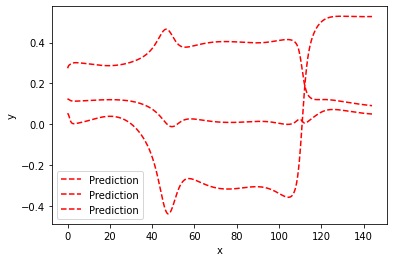

In [ ]:
model.compile("adam", lr=0.001, loss_weights=[1.6,1.6,1.8,2.5,2.5])
losshistory, train_state=model.train(epochs=25000, callbacks=cb)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
'compile' took 1.003224 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
19000     [3.01e-01, 4.06e-01, 8.12e+00, 4.21e-01, 6.37e-01]    [3.01e-01, 4.05e-01, 8.12e+00, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: nan
  Number of iterations: 0
  Number of functions evaluations: 51
19101     [3.01e-01, 4.06e-01, 8.12e+00, 4.21e-01, 6.37e-01]    [3.01e-01, 4.05e-01, 8.12e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 17000:
  train loss: 9.67e+00
  test loss: 8.34e+00
  test metric: []

Epoch 19101: saving model to model_norm/modelo.ckpt-19101 ...

INFO:tensorflow:model_norm/modelo.ckpt-19101 is not in all_model_checkpoint_paths. Manually adding it.
'train' took 6.786936 s

Restoring model from model_norm/modelo.ckpt-17000 ...

INFO:tensorflow:Restoring parameter

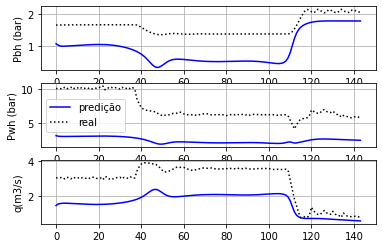

In [ ]:

model.compile("L-BFGS-B",loss_weights=[1,1,1,2,2])
losshistory, train_state = model.train(callbacks=cb,model_save_path='model_norm/modelo.ckpt')
modelo1='model_norm/modelo.ckpt-'+str(train_state.best_step)
previsao(modelo1,[x1,x2,x3],tempo)


In [25]:
model.restore('model_norm/modelo.ckpt-43000',verbose=1)

Restoring model from model_norm/modelo.ckpt-43000 ...

INFO:tensorflow:Restoring parameters from model_norm/modelo.ckpt-43000


Restoring model from model_norm/modelo.ckpt-43000 ...

INFO:tensorflow:Restoring parameters from model_norm/modelo.ckpt-43000
Predicting...
'predict' took 0.011574 s



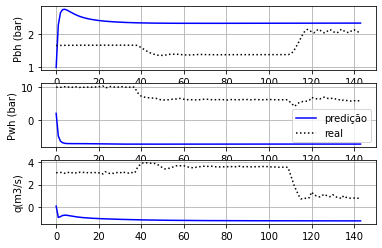

In [50]:
modelo1='model_norm/modelo.ckpt-43000'
previsao(modelo1,[x1,x2,x3],tempo)

In [80]:
  X = geom.random_points(300)
  f = model.predict(X, operator=ED_BCS)
  

 

Predicting...
'predict' took 0.669813 s



In [84]:
eixo=2

err_eq = np.absolute(f[eixo])
err = np.mean(err_eq)
err_eq.shape
x_id = np.argmax(err_eq,0)
x_id.shape
#print(err_eq.shape)
x_id

array([182])

In [85]:
24*8,1

(192, 1)